In [3]:
import tensorflow as tf
from sklearn import metrics
import seaborn as sns; sns.set()
import pickle
from tensorflow import keras
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed
from keras.layers import Embedding
from keras.layers import Conv1D, Conv2D, GlobalAveragePooling1D, MaxPooling1D, Bidirectional, LSTM, MaxPooling2D, MaxPooling3D, AveragePooling2D
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
import sys

Using TensorFlow backend.


ACGT H3K4me1 H3K4 H3K36 DNase 

In [4]:
def load_spots(chromosome):
    with open("data/spots/"+chromosome+"_hotspot_data.txt", "rb") as fp:
         hotspot_data = pickle.load(fp)
    with open("data/spots/"+chromosome+"_coldspot_data.txt", "rb") as fp:
         coldspot_data = pickle.load(fp)
    return hotspot_data, coldspot_data

def create_dataset(hotspots, coldspots, only_seq=False, flatten=False):
    X, y = [], []
    for row in hotspots:
#         if only_seq: row = row[:, :4]
        if only_seq: row = row[:, :4]
        if flatten: row = row.flatten()
        X.append(row)
        y.append(1)
    
    for row in coldspots:
#         if only_seq: row = row[:, :4]
        if only_seq: row = row[:, :4]
        if flatten: row = row.flatten()
        X.append(row)
        y.append(0)
    
    return X, y

In [5]:
data, labels = [], []
for i in range(17, 20):
    hotspots, coldspots = load_spots('chr'+str(i))
    X, y = create_dataset(hotspots, coldspots, only_seq=False, flatten=False)
    data += X
    labels += y

In [8]:
data = np.array(data).reshape(5626, 1000, 8, 1)
# data = np.array(data).reshape(15248, 1, 8000)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(5626, 1000, 8, 1)
(5626,)


In [12]:
model = Sequential()
model.add(Conv2D(1, (10, 8), activation='relu', input_shape=(1000, 8, 1), padding='same'))
model.add(Dropout(0.4))
model.add(AveragePooling2D(pool_size=(2, 1)))
model.add(Conv2D(1, (10, 8), activation='relu', padding='same'))
model.add(Dropout(0.4))
model.add(AveragePooling2D(pool_size=(2, 1)))
model.add(Conv2D(1, (10, 8), activation='relu', padding='same'))
model.add(Dropout(0.4))
model.add(AveragePooling2D(pool_size=(2, 1)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1000, 8, 1)        81        
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 8, 1)        0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 500, 8, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 500, 8, 1)         81        
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 8, 1)         0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 250, 8, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 250, 8, 1)         81        
__________

In [17]:
model = Sequential()
model.add(Flatten(input_shape=(1000, 8, 1)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               800100    
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 800,201
Trainable params: 800,201
Non-trainable params: 0
_________________________________________________________________


In [16]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8, test_size=0.2, random_state = 0)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=1)
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=100, epochs=10)

Train on 3600 samples, validate on 900 samples
Epoch 1/10
3600/3600 [==============================] - 20s 6ms/step - loss: 0.7059 - acc: 0.5047 - val_loss: 0.6948 - val_acc: 0.4822
Epoch 2/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.6925 - acc: 0.5286 - val_loss: 0.6928 - val_acc: 0.4967
Epoch 3/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.6901 - acc: 0.5289 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 4/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.6873 - acc: 0.5436 - val_loss: 0.6932 - val_acc: 0.5067
Epoch 5/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.6830 - acc: 0.5558 - val_loss: 0.6995 - val_acc: 0.5000
Epoch 6/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.6884 - acc: 0.5592 - val_loss: 0.6934 - val_acc: 0.5056
Epoch 7/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.6762 - acc: 0.5708 - val_loss: 0.6989 - val_acc: 0.4989
Epoch 8/

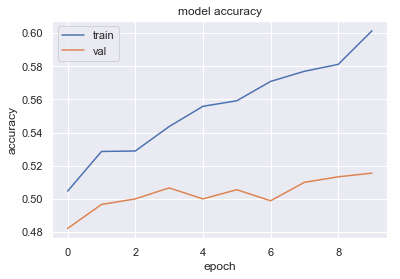

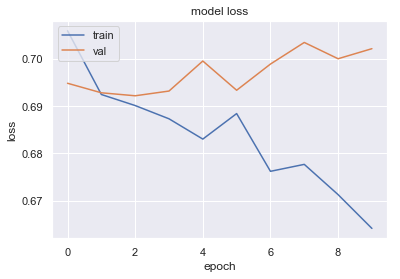

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

0.47513321492007105


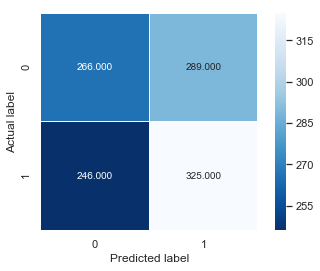

In [19]:
ypred = model.predict_classes(x_test)
print(MSE(ypred, y_test))
result = metrics.confusion_matrix(y_test, ypred)
sns.heatmap(result, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [138]:
model.predict(x_test)

array([[0.5442992 ],
       [0.546906  ],
       [0.5462485 ],
       [0.5450153 ],
       [0.5493584 ],
       [0.5457002 ],
       [0.5467543 ],
       [0.5448737 ],
       [0.5457312 ],
       [0.5444651 ],
       [0.5415389 ],
       [0.5424977 ],
       [0.5450948 ],
       [0.5464425 ],
       [0.5450269 ],
       [0.54780525],
       [0.54811794],
       [0.54515314],
       [0.5473066 ],
       [0.54706806],
       [0.5465767 ],
       [0.5462527 ],
       [0.5468905 ],
       [0.5473855 ],
       [0.5475477 ],
       [0.5446647 ],
       [0.5475337 ],
       [0.5474241 ],
       [0.54887927],
       [0.54664075],
       [0.54513764],
       [0.5441045 ],
       [0.5466963 ],
       [0.547902  ],
       [0.54678035],
       [0.5468512 ],
       [0.5483214 ],
       [0.5456147 ],
       [0.5466538 ],
       [0.5448332 ],
       [0.5461731 ],
       [0.546421  ],
       [0.5459354 ],
       [0.5484855 ],
       [0.5434768 ],
       [0.5423161 ],
       [0.545466  ],
       [0.546

In [139]:
model.predict_classes(x_test)

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    